In [0]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import Imputer, VectorAssembler
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col


#create Spark Session
spark = SparkSession.builder.appName('house_price_prediction').getOrCreate()
train_data = spark.read.csv("dbfs:/FileStore/tables/train-2.csv", header=True, inferSchema=True)
test_data = spark.read.csv("dbfs:/FileStore/tables/test.csv", header=True, inferSchema=True)

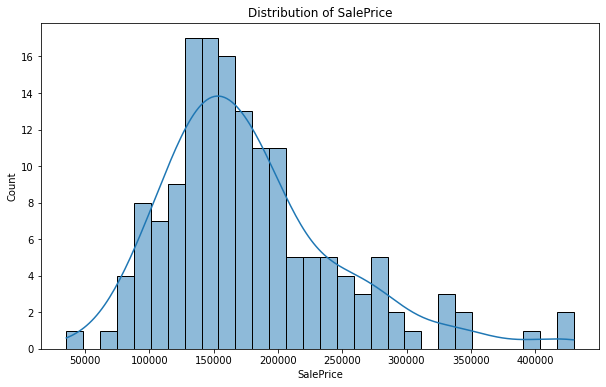

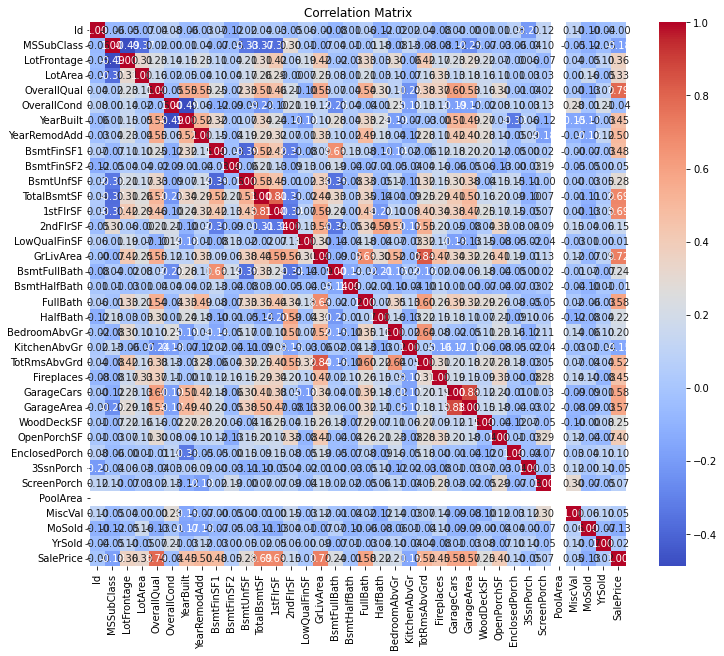

In [0]:
# Sample a fraction of the data for visualization
train_data_sample = train_data.sample(fraction=0.1).toPandas()

# Visualization of SalePrice distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_data_sample['SalePrice'], bins=30, kde=True)
plt.title('Distribution of SalePrice')
plt.show()

# Creating a correlation heatmap (after converting to pandas DataFrame)
numeric_columns = [col_name for col_name, dtype in train_data.dtypes if dtype in ['int', 'double']]
train_data_sample_numeric = train_data_sample[numeric_columns]
corr_matrix = train_data_sample_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [0]:
# Imputing missing values
imputer = Imputer(inputCols=["LotFrontage"], outputCols=["LotFrontage"])
train_data = imputer.fit(train_data).transform(train_data)

# Assembling features into a single vector column
assembler = VectorAssembler(inputCols=["LotFrontage"], outputCol="features")
train_data = assembler.transform(train_data)

In [0]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Splitting the data into training and testing sets
train, test = train_data.randomSplit([0.8, 0.2], seed=12345)

# Define the model
lr = LinearRegression(featuresCol='features', labelCol='SalePrice')

# Fit the model
lrModel = lr.fit(train)

# Predictions
predictions = lrModel.transform(test)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 71184.7


In [0]:
# Cache the DataFrame if it is used multiple times
train_data.cache()

# Tune the number of partitions for optimization
train_data = train_data.repartition(200)

In [0]:
# Register DataFrame as a SQL temporary view for SQL queries
train_data.createOrReplaceTempView("train_data")
spark.sql("SELECT * FROM train_data WHERE SalePrice > 50000")

# Example of using window functions
windowSpec = Window.partitionBy("Neighborhood").orderBy(col("SalePrice").desc())
ranked_data = train_data.withColumn("rank", rank().over(windowSpec))